# Training a conventional Single-Output GP with GPytorch
(based on https://github.com/cornellius-gp/gpytorch/blob/main/examples/01_Exact_GPs/Simple_GP_Regression.ipynb)

In [1]:
import math

import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2
torch.manual_seed(42)
None

## Set up some training data

$$
\begin{align}
y &= \sin(2\pi x) + \epsilon \\
  \epsilon &\sim \mathcal{N}(0, 0.04)
\end{align}
$$
With 100 training examples (regularly spaced points in [0,1]) and 51 test examples

In [2]:
# training data, 100 points in [0,1]
train_x = torch.linspace(0, 1, 100)
train_y = torch.sin(2 * math.pi * train_x) + torch.randn(train_x.size()) * math.sqrt(0.04)

## Setting up the model
A **GP Model** `gpytorch.models.ExactGP` with:
- **Likelihood** `gpytorch.likelihoods.GaussianLikelihood`
- **Zero Mean** `gpytorch.means.ZeroMean` for simplicity
- **RBF Kernel** `gpytorch.kernels.RBFKernel`

forward method returns the vector $\mu(x)$ and the $N \times N$ matrix $K_{xx}$ (forward methods are called by `__call__` method of parent `gpytorch.Module`)
- forward method of RBF Kernel calculates $k_{\text{RBF}}(x_1, x_2) = \exp \left( -\frac{1}{2}(\mathbf{x_1} - \mathbf{x_2})^\top \Theta^{-2} (\mathbf{x_1} - \mathbf{x_2}) \right)$ with $\Theta$ as the lengthscale parameter


In [3]:
class ConventionalGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ConventionalGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.RBFKernel()

    def forward(self, x):
        r"""
        Takes in some n x d data :math:`\mathbf{x}` and returns a :obj:`~gpytorch.distributions.MultivariateNormal` with prior mean and covariance matrix of the GP
        :param x:
        :return:
        """
        # calling the forward method of the respective module to get mean vector and covariance matrix
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# init likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ConventionalGPModel(train_x, train_y, likelihood)

## Training the model

- Using Type-II MLE with custom training loop, as in standard PyTorch
- All trainable parameters should be of type `torch.nn.Parameter`, since GP models extend `torch.nn.Module`

Standard PyTorch training loop:
1. Zero all parameter gradients
2. Call the model and compute loss:
    - `output = model(train_x)`: get multivariate normal with $\mu_*$ and $\Sigma_*$
    - `loss = -mll(output, train_y)`: calculate negative log likelihood
        - calls `log_prob` method with `value=train_y` of `output` (multivariate normal of model)
        - inverse of and log of determinant calculated by `linear_operator.operator._linear_operator().inv_quad_logdet` based on covariance matrix of `output`
3. Call backward on loss to fill in gradients
    - tensors (`model.parameters()`) "store" gradients themselves (with `grad` and `requires_grad` attributes) after call to `loss.backward()` which computes all gradients for all tensors
4. Take a step on the optimizer
    - `optimizer.step()` iterates over all parameters and updates them internally, using the stored `grad` (i.e. using Adam algorithm)

In [4]:
# set model in training mode
model.train()
likelihood.train()

# use adam optimizer, including the GaussianLikelihood parameters
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for GPs - marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(50):
    # zero gradients from previous iteration
    optimizer.zero_grad()

    # output from model -> multivariate normal with mean vector and covariance matrix
    output = model(train_x)

    # calc loss (negative marginal log likelihood) and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()

    if i == 0 or (i + 1) % 10 == 0:
        print(
            f'Iter {i + 1:02d}/50 - '
            f'Loss: {loss.item():.3f}   '
            f'lengthscale: {model.covar_module.lengthscale.item():.3f}   '
            f'noise: {model.likelihood.noise.item():.3f}'
        )

    # step on optimizer
    optimizer.step()

Iter 01/50 - Loss: 0.936   lengthscale: 0.693   noise: 0.693
Iter 10/50 - Loss: 0.550   lengthscale: 0.341   noise: 0.339
Iter 20/50 - Loss: 0.189   lengthscale: 0.191   noise: 0.134
Iter 30/50 - Loss: -0.057   lengthscale: 0.190   noise: 0.053
Iter 40/50 - Loss: -0.080   lengthscale: 0.199   noise: 0.028
Iter 50/50 - Loss: -0.081   lengthscale: 0.188   noise: 0.028


## Make predictions with the model

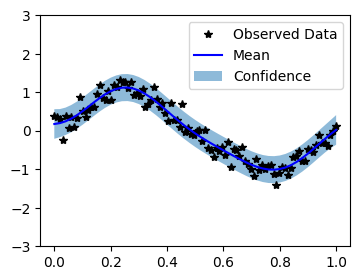

In [5]:
# set model to evaluation mode (predictive posterior)
model.eval()
likelihood.eval()

# test points are regularly spaced along [0, 1]
# make predictions by feeding model through likelihood
with torch.no_grad():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))

# plot model fit
# initialize plot
f, ax = plt.subplots(1, 1, figsize=(4, 3))
# get upper and lower confidence bounds
lower, upper = observed_pred.confidence_region()
# plot training data as black stars
ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
# plot predictive means as blue line
ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
# shade between lower and upper confidence bounds
ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
ax.set_ylim([-3, 3])

ax.legend(['Observed Data', 'Mean', 'Confidence'])
None

- User defined model returns `MultivariateNormal` with prior mean and covariance from forward
- Trained model in eval mode returns `MultivariateNormal` with posterior mean and covariance

A test point (`test_x`) denoted as `X*` with true output `Y*` and training data `X, Y`:
- `model(test_x)` returns model posterior distribution `p(f* | X*, X, Y)`
    - posterior is distribution over the function we are trying to model and thus quantifies model uncertainty
- `likelihood(model(test_x))` gives us posterior predictive distribution `p(Y* | X*, X, Y)`
    - probability distribution over predicted output value

Getting mean, variance and covariance matrix and sampling functions from GP:

In [7]:
f_preds = model(test_x)
y_pred = likelihood(model(test_x))

f_mean = f_preds.mean
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix
f_samples = f_preds.sample(sample_shape=torch.Size((1,)))
print(f_samples[0,])

Train:
mean:		 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
var:		 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
covar:		 tensor([[1.0000e+00, 9.9859e-01, 9.9435e-01,  ..., 1.6414e-06, 1.2454e-06,
				